# Network training: non-linear curve fitting (with JAX)
## Function comparison
### The target and approximate functions
Consider the target function $f_{\rm t}(x)$ represented as `f_target` in the code. We want to approximate this function using an ansatz $f_\theta(x)$ represented as `f_approx` with a set of free parameters $\theta = \{\theta_i\}$ represented as `theta`. We would like to tune the parameters $\theta$ such that $f_\theta(x)$ approximates the original function $f_{\rm t}(x)$.

In [1]:
def f_target(x):
    """
    Target function to be approximated.

    Args:
        x: Input values (scalar or array)

    Returns:
        Function values using Lorentzian-like shape centered at 0.5
    """
    return 3 / (1 + (x - 0.5) ** 2)


def f_approx(theta, x):
    """
    Parameterized approximation function.

    Args:
        theta: Parameters [amplitude, center] for the approximation
        x: Input values (scalar or array)

    Returns:
        Function values using learnable Lorentzian-like shape
    """
    return theta[0] / (1 + (x - theta[1]) ** 2)

### Test

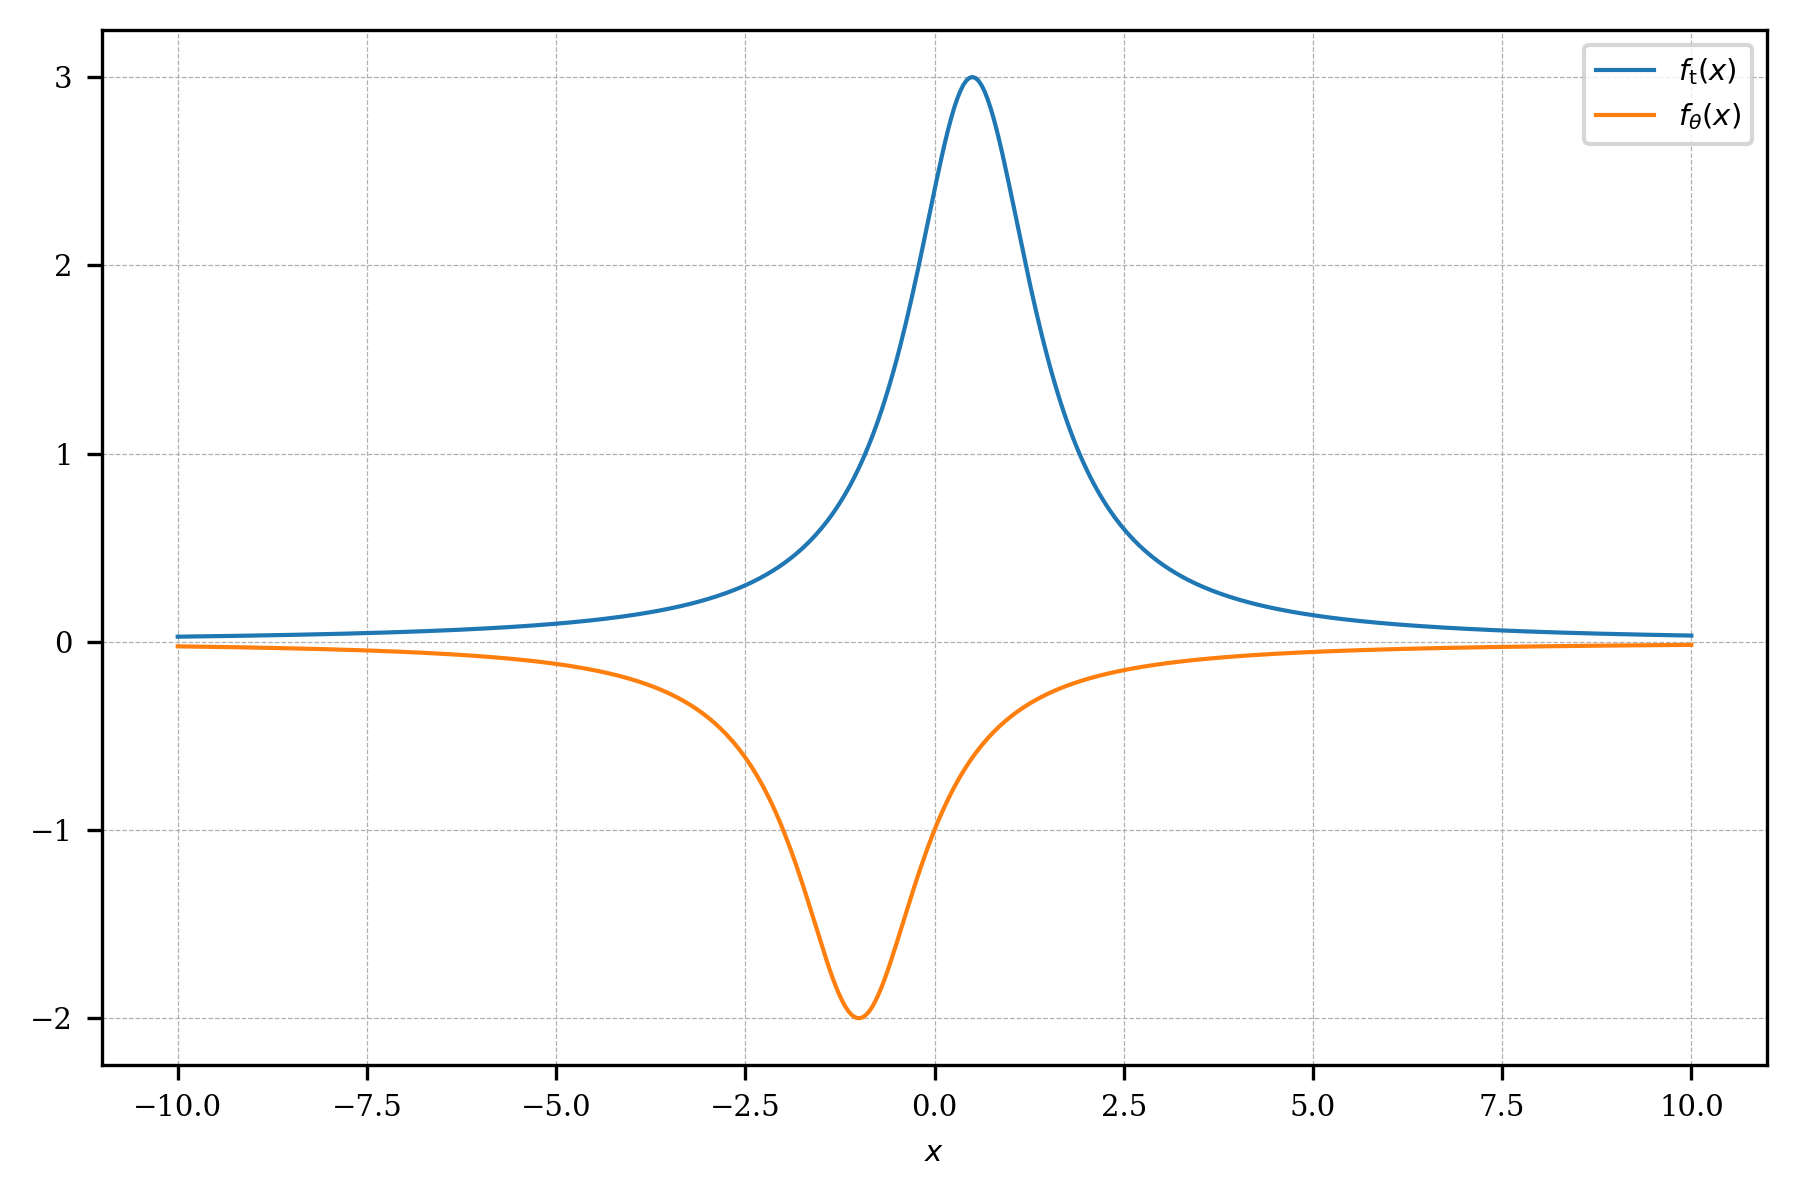

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300

# Define parameter sets for comparison
theta_test = [-2, -1]  # Initial/test parameters
theta_true = [3, 0.5]  # True target parameters

# Generate input range for visualization
x_range = jnp.linspace(-10, 10, 500)

# Create function comparison plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot target function and current approximation
ax.plot(x_range, f_target(x_range), label=r"$f_{\rm t}(x)$", linewidth=1)
ax.plot(x_range, f_approx(theta_test, x_range), label=r"$f_\theta(x)$", linewidth=1)

# Configure plot appearance and styling
ax.set_xlabel(r"$x$")
ax.grid(True, linestyle="--", linewidth=0.3)
ax.legend()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)

# Finalize and display plot
plt.tight_layout()
plt.show()

### Visualization using sampling

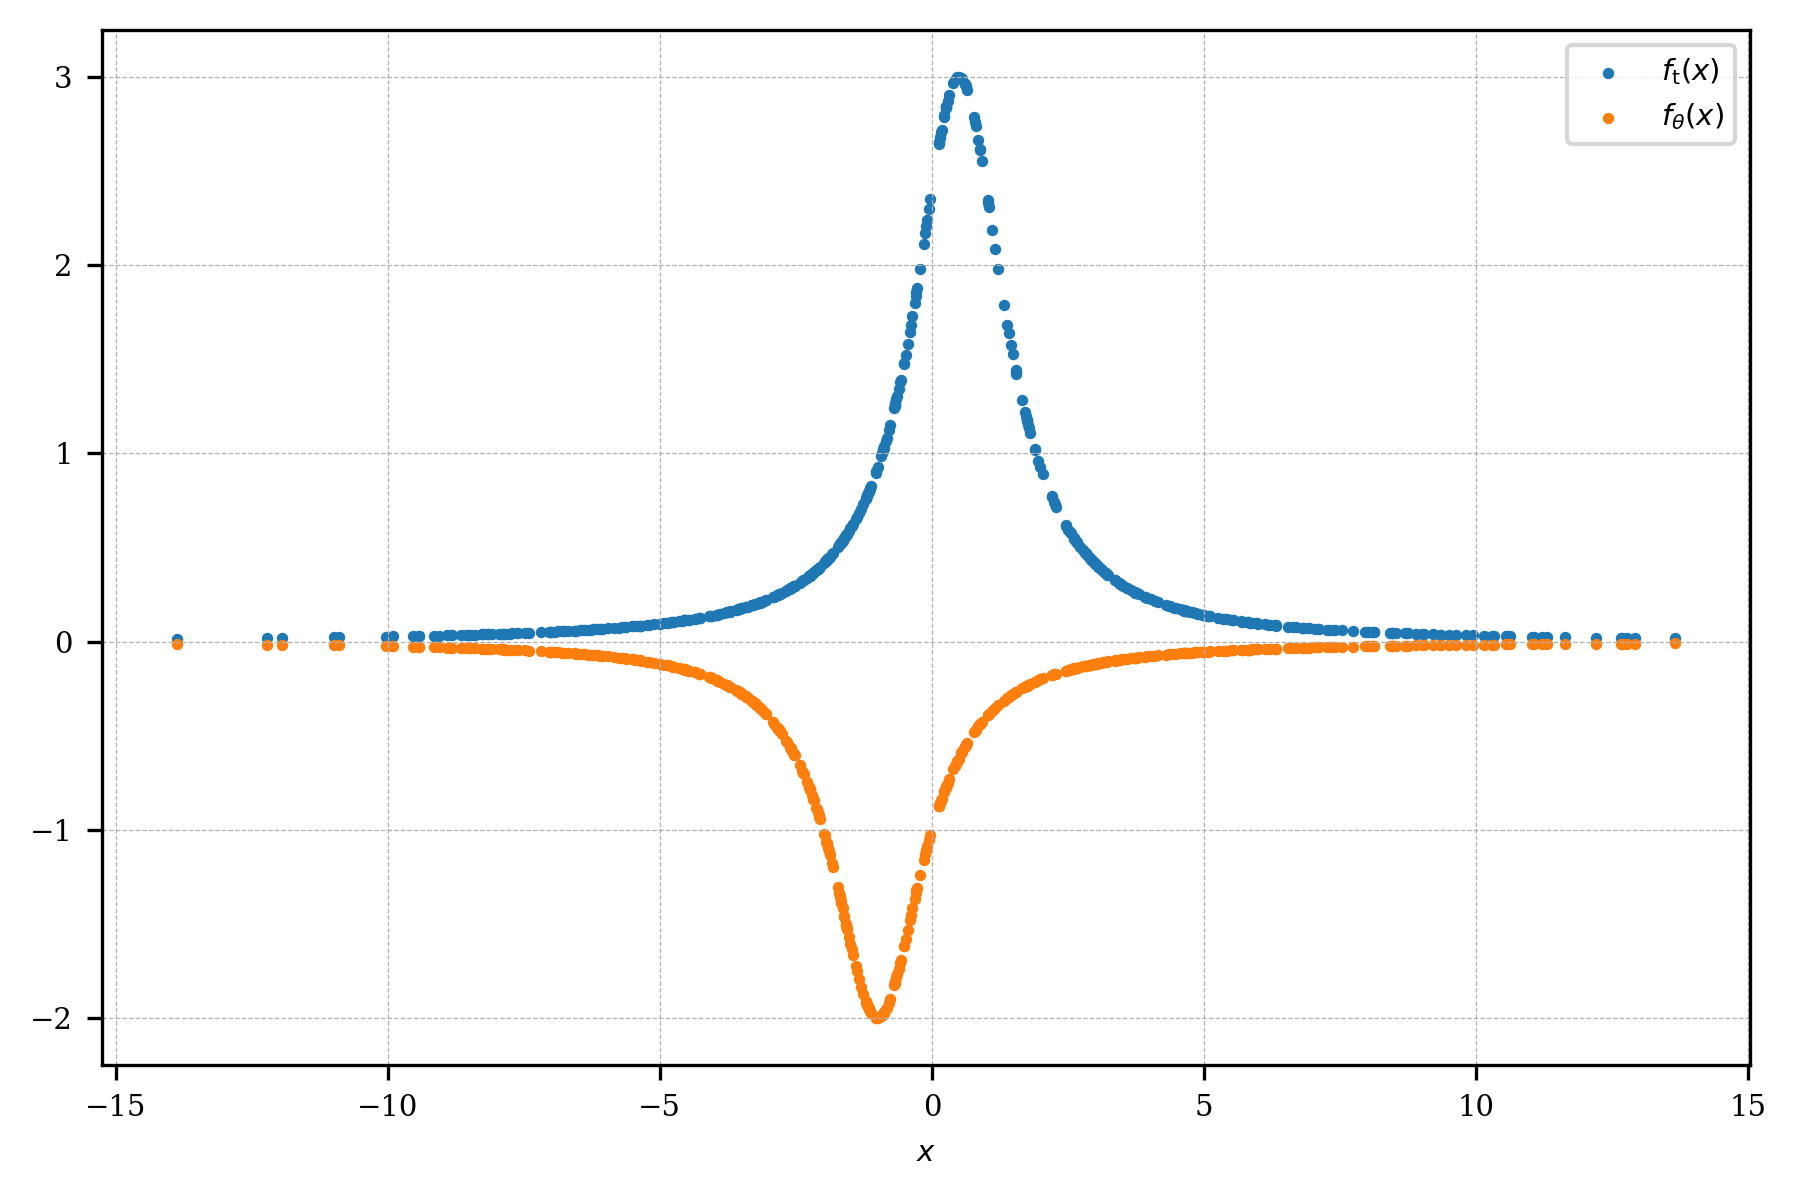

In [3]:
import jax
import matplotlib.pyplot as plt

# Generate random sample points for function evaluation
key = jax.random.PRNGKey(42)
mu = 0
sigma = 5
x_sample = mu + sigma * jax.random.normal(key, shape=(500,))

# Create scatter plot comparison of functions
fig, ax = plt.subplots(figsize=(6, 4))

# Plot function values at sampled points
ax.scatter(x_sample, f_target(x_sample), label=r"$f_{\rm t}(x)$", s=3)
ax.scatter(x_sample, f_approx(theta_test, x_sample), label=r"$f_\theta(x)$", s=3)

# Configure plot appearance and styling
ax.set_xlabel(r"$x$")
ax.grid(True, linestyle="--", linewidth=0.3)
ax.legend()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)

# Finalize and display plot
plt.tight_layout()
plt.show()

### Cost function analysis
We introduce an averaged cost function. Minimizing the averaged cost function helps us to tune the parameters $\theta$, such that the function $f_\theta(x)$ resembles the function $f_{\rm t}(x)$. The averaged cost function is defined as $c(\theta) = \frac{1}{N} \sum_{i=1}^N C(\theta, x_i) = \frac{1}{2N} \sum_{i=1}^N (f_\theta(x_i) - f_{\rm t}(x_i))^2$.

In [4]:
import jax
import jax.numpy as jnp

# Updated test parameters for cost evaluation
theta_test = [-15, 21]


def average_cost(theta, num_samples, mean, stdev):
    """
    Compute average squared error cost between approximation and target.

    Args:
        theta: Parameters [amplitude, center] for approximation function
        num_samples: Number of random samples for Monte Carlo estimation
        mean: Mean of the sampling distribution
        stdev: Standard deviation of the sampling distribution

    Returns:
        Average squared error cost scaled by 1/2
    """
    # Generate random sample points from normal distribution
    key = jax.random.PRNGKey(42)
    x_sample = mean + stdev * jax.random.normal(key, shape=(num_samples,))

    # Compute mean squared error with 1/2 scaling factor
    average = jnp.mean((f_approx(theta, x_sample) - f_target(x_sample)) ** 2) / 2
    return average


# Vectorize cost function for batch parameter evaluation
_average_cost_vectorized = jax.vmap(average_cost, in_axes=(0, None, None, None))


def average_cost_vectorized(theta, num_samples, mean=0, stdev=1):
    """
    Vectorized version for evaluating cost on multiple parameter sets.

    Args:
        theta: Batch of parameter sets, shape (batch_size, 2)
        num_samples: Number of samples for each cost evaluation
        mean: Mean of sampling distribution (default: 0)
        stdev: Standard deviation of sampling distribution (default: 1)

    Returns:
        Array of cost values for each parameter set
    """
    return _average_cost_vectorized(theta, num_samples, mean, stdev)


# Evaluate cost function for current test parameters
print(
    f"The averaged cost function for theta_test: {average_cost(theta_test, num_samples=1000, mean=0, stdev=5)}"
)

The averaged cost function for theta_test: 0.5764387845993042


### Cost landscape

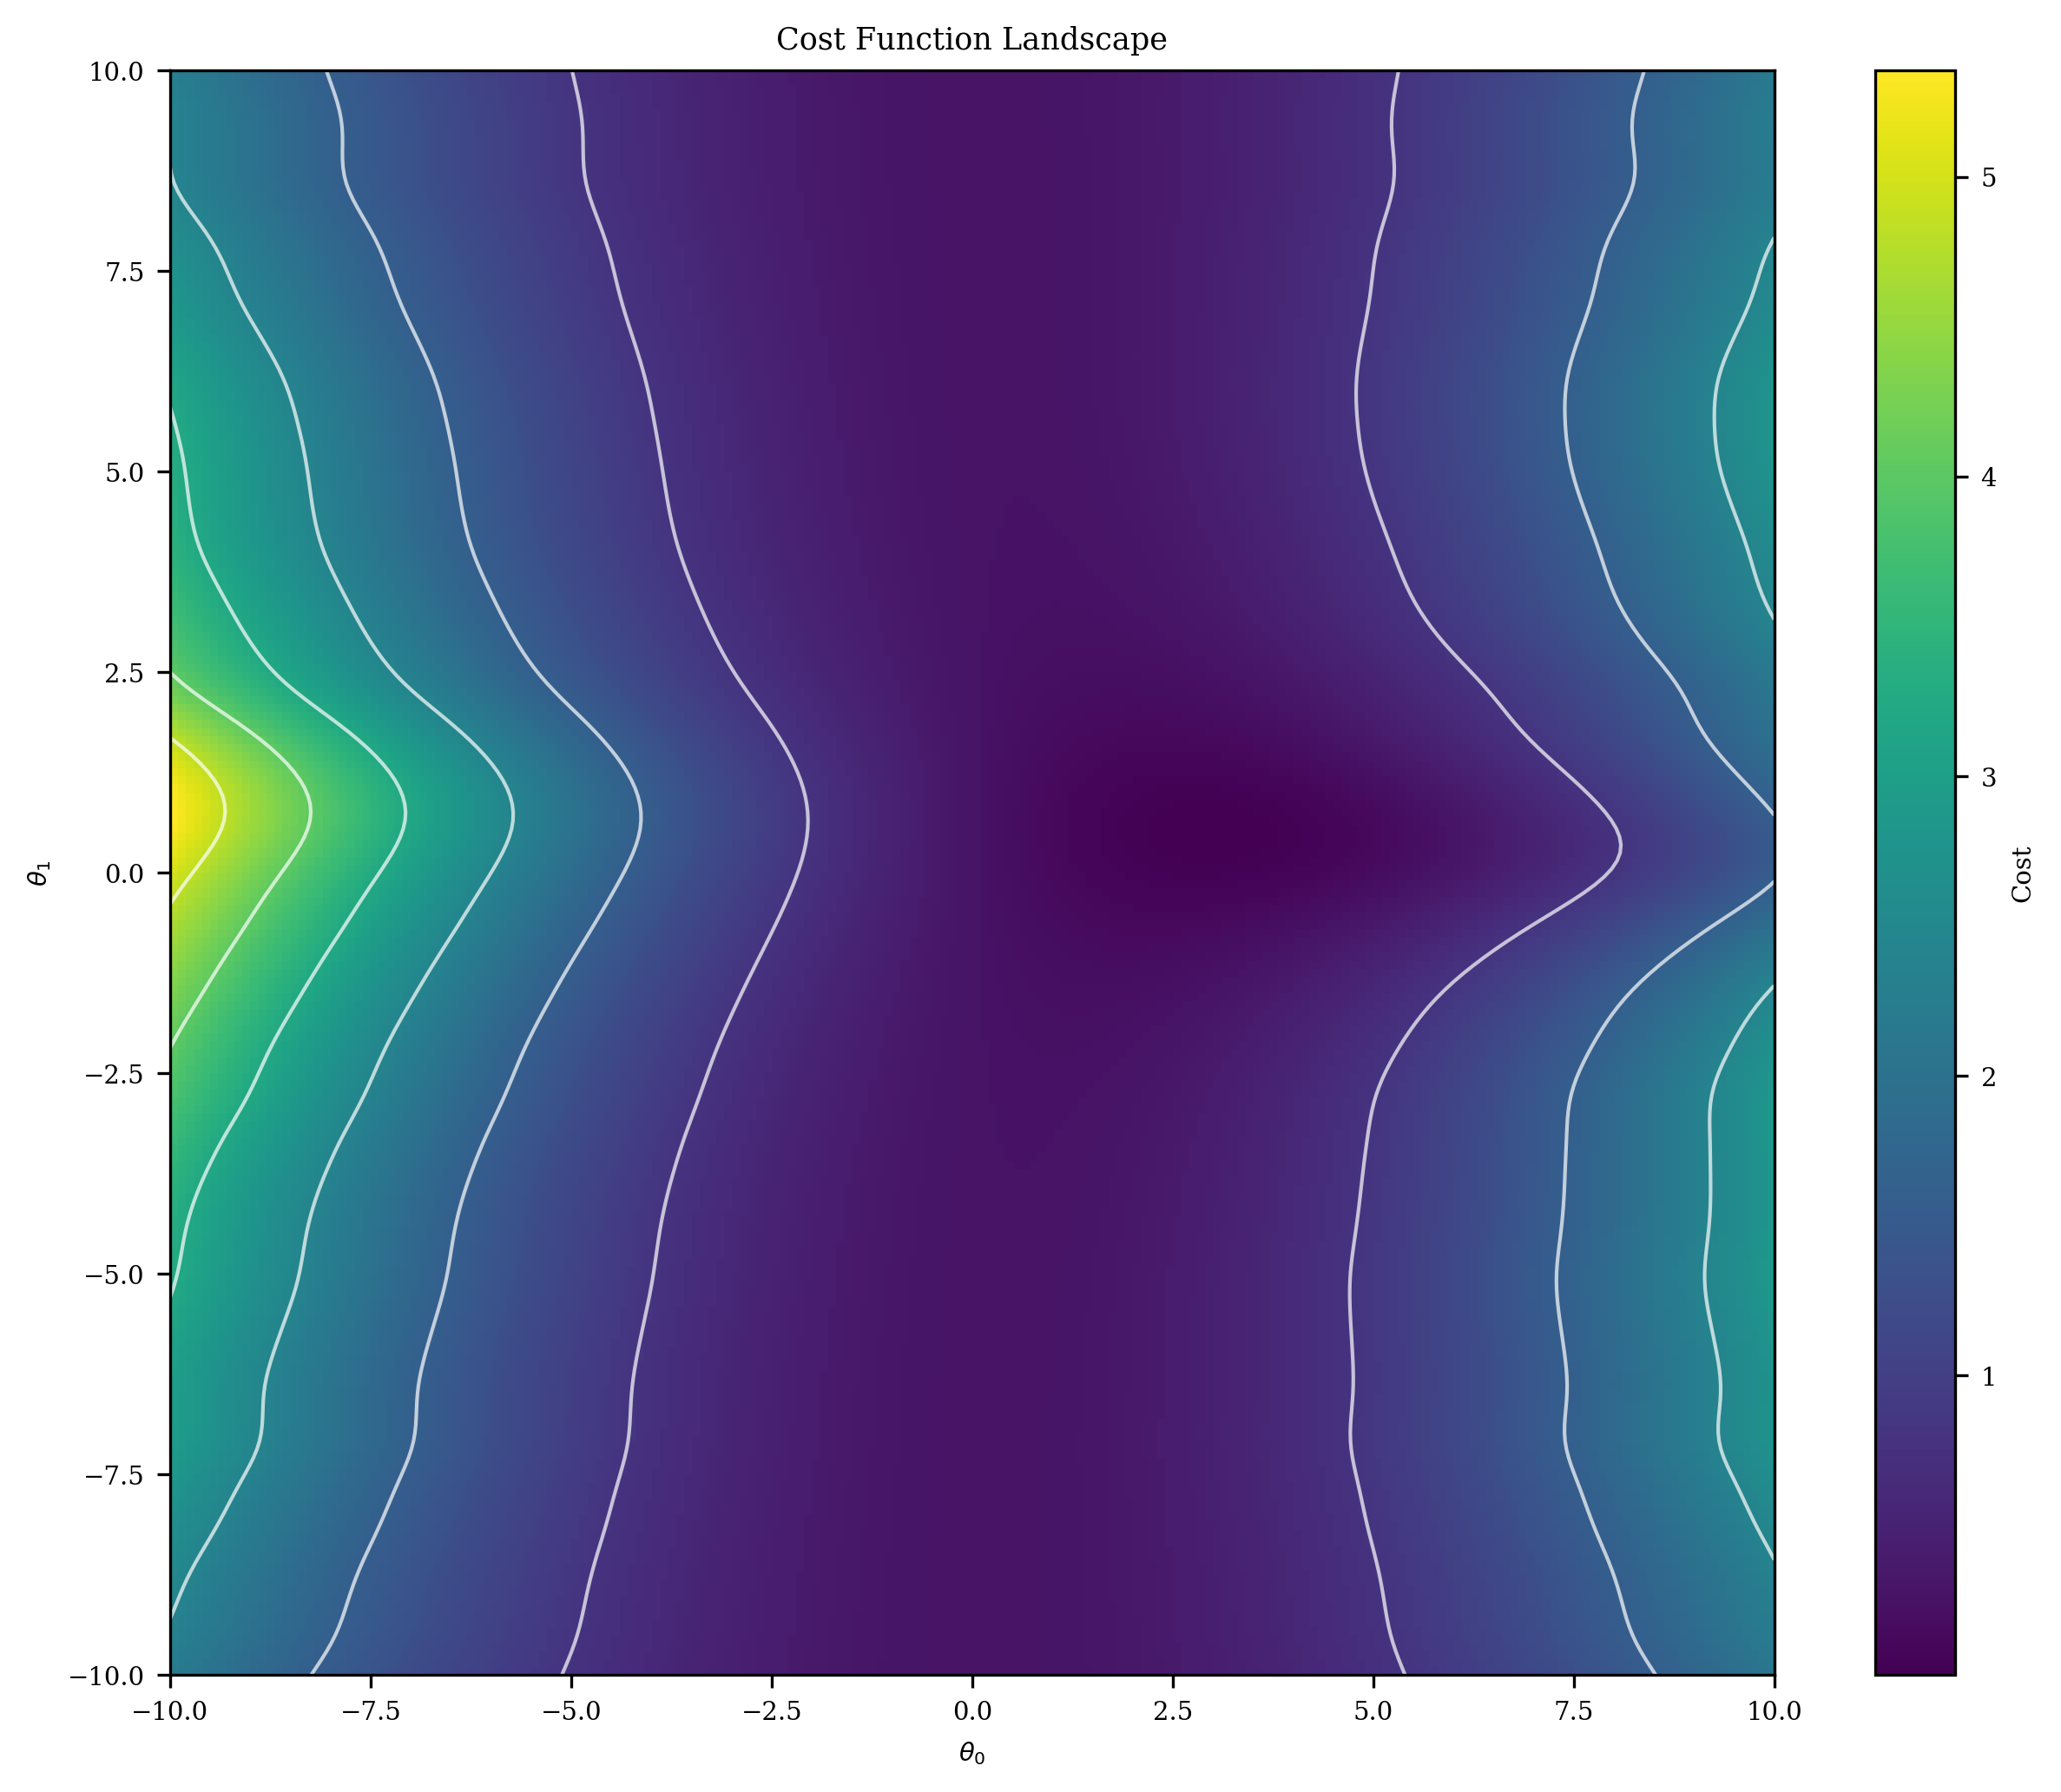

In [5]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define parameter grid for cost landscape visualization
resolution = 200
theta0_vals = jnp.linspace(-10, 10, resolution)
theta1_vals = jnp.linspace(-10, 10, resolution)
theta0_flat, theta1_flat = jnp.meshgrid(theta0_vals, theta1_vals)

# Create parameter array for vectorized cost computation
theta_array = jnp.vstack([theta0_flat.ravel(), theta1_flat.ravel()]).T

# Compute cost values across parameter space using high sample count
cost_flat = average_cost_vectorized(theta_array, 10000, mean=0, stdev=10).T
cost_grid = cost_flat.reshape(resolution, resolution)

# Create cost landscape visualization
plt.figure(figsize=(10, 8))
plt.imshow(cost_grid, extent=(-10.0, 10.0, -10.0, 10.0), origin="lower", cmap="viridis")
plt.colorbar(label="Cost")

# Overlay contour lines for better visualization of cost structure
plt.contour(
    theta0_vals, theta1_vals, cost_grid, colors="white", alpha=0.7, linewidths=1
)

# Configure plot labels and display
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.title("Cost Function Landscape")
plt.show()

## Gradient-based optimization
### The gradient of the function
The gradient of the function is simply $\{\partial f_\theta(x) / \partial \theta^i\}$.

In [6]:
import jax


def grad_f_manual(theta, x):
    """
    Manually computed gradient of f_approx with respect to theta.

    Args:
        theta: Parameters [amplitude, center]
        x: Input value(s)

    Returns:
        List containing partial derivatives [df/dtheta0, df/dtheta1]
    """
    # Compute common denominator term
    denom = 1 + (x - theta[1]) ** 2

    # Partial derivative with respect to theta[0] (amplitude)
    grad1 = 1 / denom

    # Partial derivative with respect to theta[1] (center)
    grad2 = 2 * (x - theta[1]) * theta[0] / denom**2

    return [grad1, grad2]


# JAX automatic differentiation for gradient computation
grad_f = jax.grad(f_approx, argnums=0)

### Test

In [7]:
# Test parameters for gradient comparison
theta_test = [-2.0, -1.2]

# Compare manual and automatic differentiation results
print(f"The derivative computed manually at x = 1: {grad_f_manual(theta_test, 1)}")
print(f"The derivative using JAX at x = 1: {grad_f(theta_test, 1)}")

The derivative computed manually at x = 1: [0.17123287671232876, -0.25802214299118026]
The derivative using JAX at x = 1: [Array(0.17123288, dtype=float32, weak_type=True), Array(-0.25802213, dtype=float32, weak_type=True)]


### Cost gradients
To compute the gradient descent, we first need to compute the gradient of the cost function, $\frac{\partial c(\theta)}{\partial \theta_i} = \frac{1}{N} \sum_{i=1}^N \left( \left( f_\theta(x_i) - f_{\rm t}(x_i) \right) \cdot \frac{\partial f_\theta(x_i)}{\partial \theta_i} \right) \equiv \left\langle \left( f_\theta(x_i) - f_{\rm t}(x_i) \right) \cdot \frac{\partial f_\theta(x_i)}{\partial \theta_i} \right\rangle$.

In [8]:
def average_cost_gradient(theta, num_samples, mu, sigma):
    """
    Compute gradient of the average cost function with respect to parameters.

    Args:
        theta: Parameters [amplitude, center] for approximation function
        num_samples: Number of random samples for Monte Carlo estimation
        mu: Mean of the sampling distribution
        sigma: Standard deviation of the sampling distribution

    Returns:
        Gradient vector of the average cost with respect to theta
    """
    # Generate random sample points from normal distribution
    key = jax.random.PRNGKey(42)
    x_sample = mu + sigma * jax.random.normal(key, shape=(num_samples,))

    # Compute prediction errors at sample points
    deviation = f_approx(theta, x_sample) - f_target(x_sample)

    # Compute gradients of approximation function at sample points
    gradient = jax.vmap(grad_f, in_axes=(None, 0))(theta, x_sample)

    # Return average gradient using chain rule: mean(error * grad_f)
    return jnp.dot(deviation, gradient) / num_samples

### Gradient descent implementation
To implement the gradient descent method, at each step, we perform the following: $\theta_{i+1} = \theta_i - \eta \nabla_\theta c(\theta)$.

In [9]:
import jax.numpy as jnp

# Configure gradient descent optimization parameters
num_samples = 500
mu = 0
sigma = 5
iterations = 50
step_size = 1

# Initialize parameters and tracking
theta_test = jnp.array([-8.0, 0.0])
theta_test_var = theta_test
theta_path = [theta_test_var]

# Perform gradient descent optimization
for n in range(iterations):
    # Update parameters using gradient descent rule
    theta_test_var -= step_size * average_cost_gradient(
        theta_test_var, num_samples, mu, sigma
    )
    # Track parameter evolution for visualization
    theta_path.append(theta_test_var)

### Gradient descent visualization

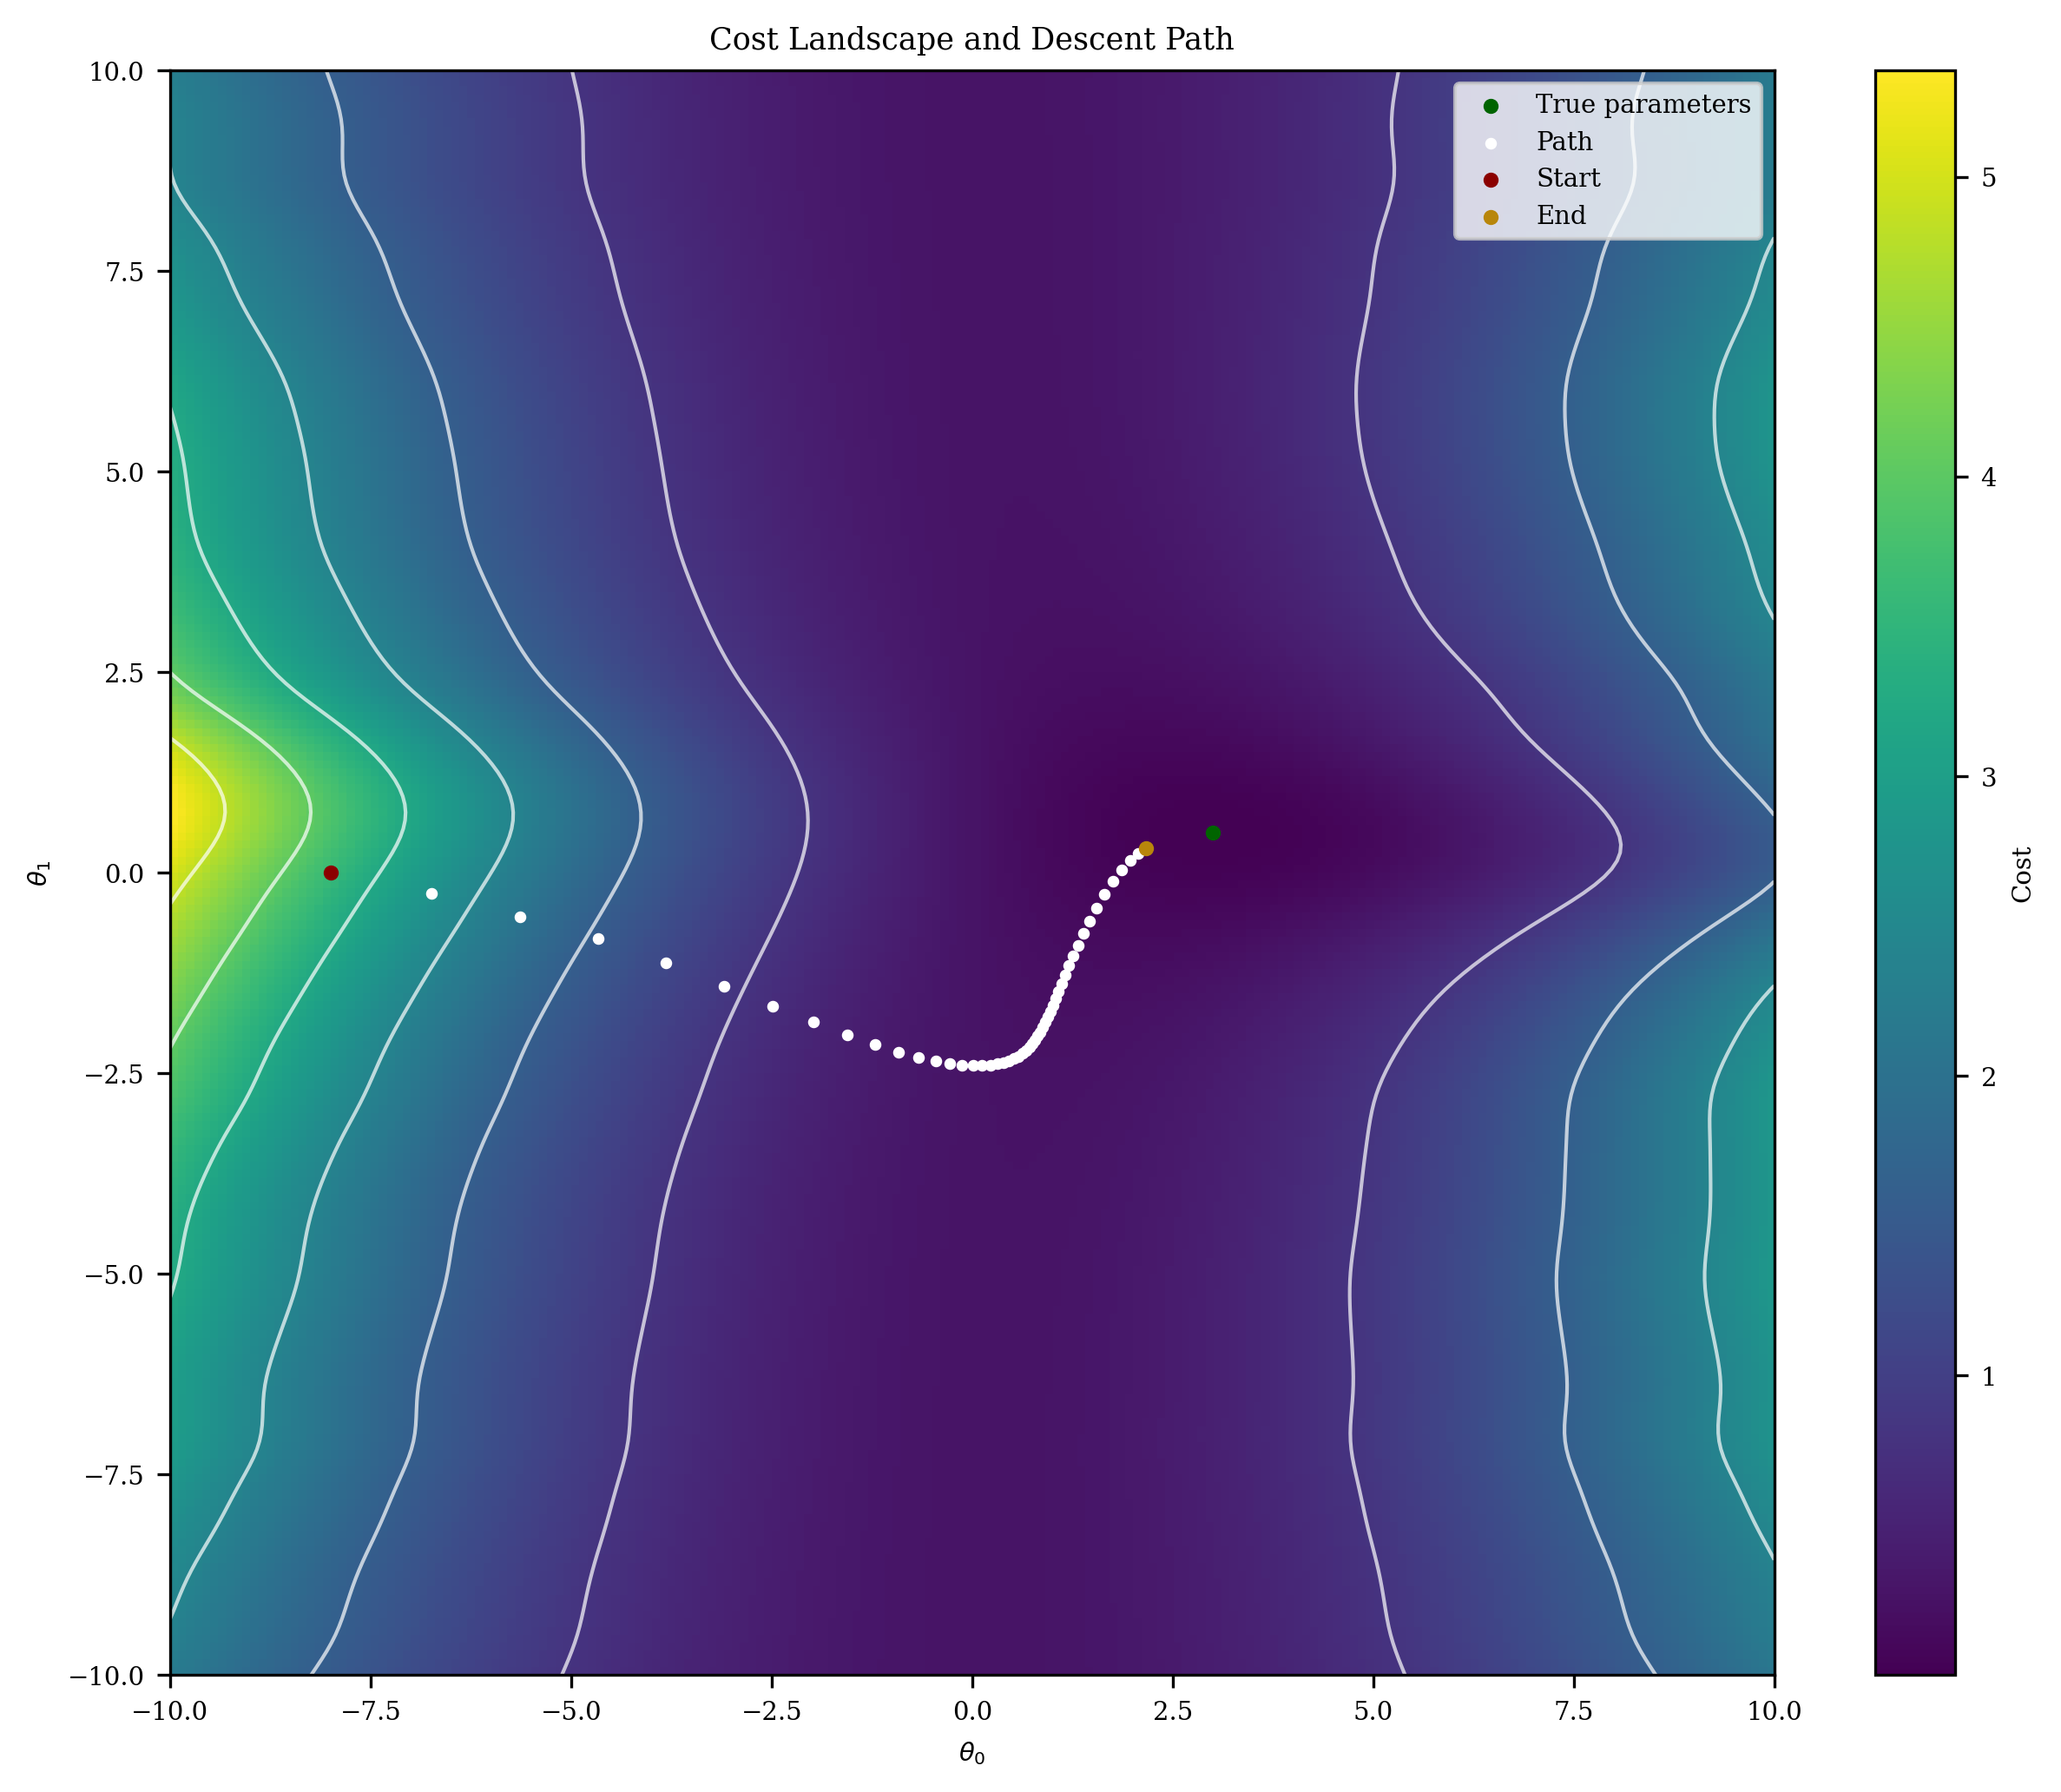

In [10]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Extract parameter trajectory coordinates for plotting
path_x_list, path_y_list = jnp.array(theta_path)[:, 0], jnp.array(theta_path)[:, 1]

# Create cost landscape visualization with optimization path
plt.figure(figsize=(10, 8))
plt.imshow(cost_grid, extent=(-10.0, 10.0, -10.0, 10.0), origin="lower", cmap="viridis")
plt.colorbar(label="Cost")

# Overlay contour lines for better cost structure visualization
plt.contour(
    theta0_vals, theta1_vals, cost_grid, colors="white", alpha=0.7, linewidths=1
)

# Plot optimization trajectory and key points
plt.scatter(
    theta_true[0], theta_true[1], color="darkgreen", s=10, label="True parameters"
)
plt.scatter(path_x_list, path_y_list, color="white", s=5, label="Path")
plt.scatter(theta_test[0], theta_test[1], color="darkred", s=10, label="Start")
plt.scatter(
    theta_path[-1][0], theta_path[-1][1], color="darkgoldenrod", s=10, label="End"
)

# Configure plot appearance and display
plt.legend()
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.title("Cost Landscape and Descent Path")
plt.show()